### Sprint 2: Model Development

In [135]:
# Feature Engineering for Water Pump Classification
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [161]:
data_path = os.path.join(os.getcwd(), '..', 'data')
out_path = os.path.join(os.getcwd(), '..', 'outputs')     # For the output

# Read the files
train = pd.read_csv(os.path.join(data_path, 'cleaned_data_filled_V6.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))

# Merge training labels
df = pd.merge(train, labels, on='id')
print('Files successfully loaded and merged!')


Files successfully loaded and merged!


## Ticket 2.1.1: New Features 

In [174]:
# Age of pump
current_year = 2025
df['pump_age'] = current_year - df['construction_year']

# Manual vs. motorized extraction
df['is_manual_pump'] = df['extraction_type_class'].str.lower().str.contains('hand').astype(int)

# water_risk_score

# 1. Water Quality + Quantity Combination: Create 'water_risk_score'
# Map water_quality into numeric risk levels
water_quality_map = {
    'soft': 1, 'good': 1,
    'salty': 2, 'milky': 2,
    'coloured': 3, 'fluoride': 3, 'fluoride, salty': 4, 'salty abandoned': 4
}
df['water_quality_numeric'] = df['water_quality'].map(water_quality_map)

# Combine amount_tsh_capped and water quality
df['water_risk_score'] = df['amount_tsh_capped'] * df['water_quality_numeric']

## Ticket 2.1.2: Transform existing features to improve model performance 

In [182]:
# First we want to see distribution of all numerical values, Select only numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

#  Drop ID and target columns
numerical_cols = [col for col in numerical_cols if col not in ['id', 'status_group_numeric']]

#Calculate skewness
from scipy.stats import skew
skewness_results = {}

for col in numerical_cols:
    skew_val = skew(df[col].dropna())
    skewness_results[col] = skew_val

# Sort by skewness
skewness_sorted = dict(sorted(skewness_results.items(), key=lambda item: abs(item[1]), reverse=True))

# Show results
print("Feature Skewness:")
for feature, skew_val in skewness_sorted.items():
    print(f"{feature}: {skew_val:.3f}")




Feature Skewness:
num_private: 90.521
amount_tsh: 56.938
water_risk_score: 8.917
has_private_owner: 8.549
amount_tsh_capped: 8.062
district_code: 3.902
population: 3.699
water_quality_numeric: 3.483
region_code: 3.142
amount_tsh_log: 1.290
amount_tsh_capped_log: 1.281
population_log: -1.278
water_risk_score_log: 1.238
pump_age: 1.232
construction_year: -1.232
is_manual_pump: 1.073
gps_height: -0.612
latitude: -0.252
recorded_year: -0.145
longitude: -0.135


#### Decision Based on Skewness Analysis
Apply log1p transformation (log(x+1)) to the following features to reduce skewness:num_private, amount_tsh, water_risk_score, amount_tsh_capped ,population, pump_age

#### For other features, no transformation is necessary at this stage.

#### New features will be saved with a _log suffix (e.g., amount_tsh_log) to preserve original columns.


In [189]:
# List of skewed columns for log-transform
skewed_cols = ['amount_tsh', 'water_risk_score', 'amount_tsh_capped', 'population' ]

# Apply log1p transformation and create new columns with _log suffix
for col in skewed_cols:
    df[col + '_log'] = np.log1p(df[col].astype(float))

In [195]:
#check the skewness after log-transforming
for col in skewed_cols:
    print(f"{col}_log skewness: {skew(df[col + '_log'].dropna()):.3f}")

amount_tsh_log skewness: 1.290
water_risk_score_log skewness: 1.238
amount_tsh_capped_log skewness: 1.281
population_log skewness: -1.278


#### num_private is extremely sparse: most pumps have no private owner (value = 0).
#### Only a tiny number of pumps have some private ownership information.
#### It's not a continuous variable in reality — it behaves like a binary feature (yes/no private ownership). 0 → No private owner 1 → Private owner exists

In [200]:
df['has_private_owner'] = (df['num_private'] > 0).astype(int)


In [204]:
# Bin pump_age into categories
df['pump_age_binned'] = pd.cut(
    df['pump_age'],
    bins=[0, 10, 30, 100],
    labels=['young', 'medium', 'old']
)

In [205]:
df.to_csv(os.path.join(data_path,"feature_engineered_data_V1.csv"), index=False)
print('Data saved successfully: feature_engineered_data_V1.csv')

Data saved successfully: feature_engineered_data_V1.csv


#### Spearman Correlation for Numerical Variables

In [210]:
data_path = os.path.join(os.getcwd(), '..', 'data')
out_path = os.path.join(os.getcwd(), '..', 'outputs')     # For the output

# Read the files
train = pd.read_csv(os.path.join(data_path, 'feature_engineered_data_V1.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))

# Drop status_group if it already exists in train
if 'status_group' in train.columns:
    train = train.drop(columns=['status_group'])
# Merge training labels
df = pd.merge(train, labels, on='id')
print('Files successfully loaded and merged!')

Files successfully loaded and merged!


In [227]:
numerical_cols= df.select_dtypes(include=np.number).columns
print("Numerical columns:", numerical_cols)

Numerical columns: Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year', 'recorded_year', 'amount_tsh_capped', 'pump_age',
       'is_manual_pump', 'water_quality_numeric', 'water_risk_score',
       'amount_tsh_log', 'water_risk_score_log', 'population_log',
       'has_private_owner'],
      dtype='object')


In [234]:
# Drop redundant originals columns
drop_cols = ['amount_tsh', 'amount_tsh_capped', 'population', 'water_risk_score']
numerical_cols = [col for col in numerical_cols if col not in drop_cols]

print(numerical_cols)

['id', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'construction_year', 'recorded_year', 'pump_age', 'is_manual_pump', 'water_quality_numeric', 'amount_tsh_log', 'water_risk_score_log', 'population_log', 'has_private_owner']


In [242]:
# Compute Spearman correlation (good for both linear and monotonic relationships)
from scipy.stats import spearmanr
spearman_corr = df[numerical_cols].corr(method='spearman')

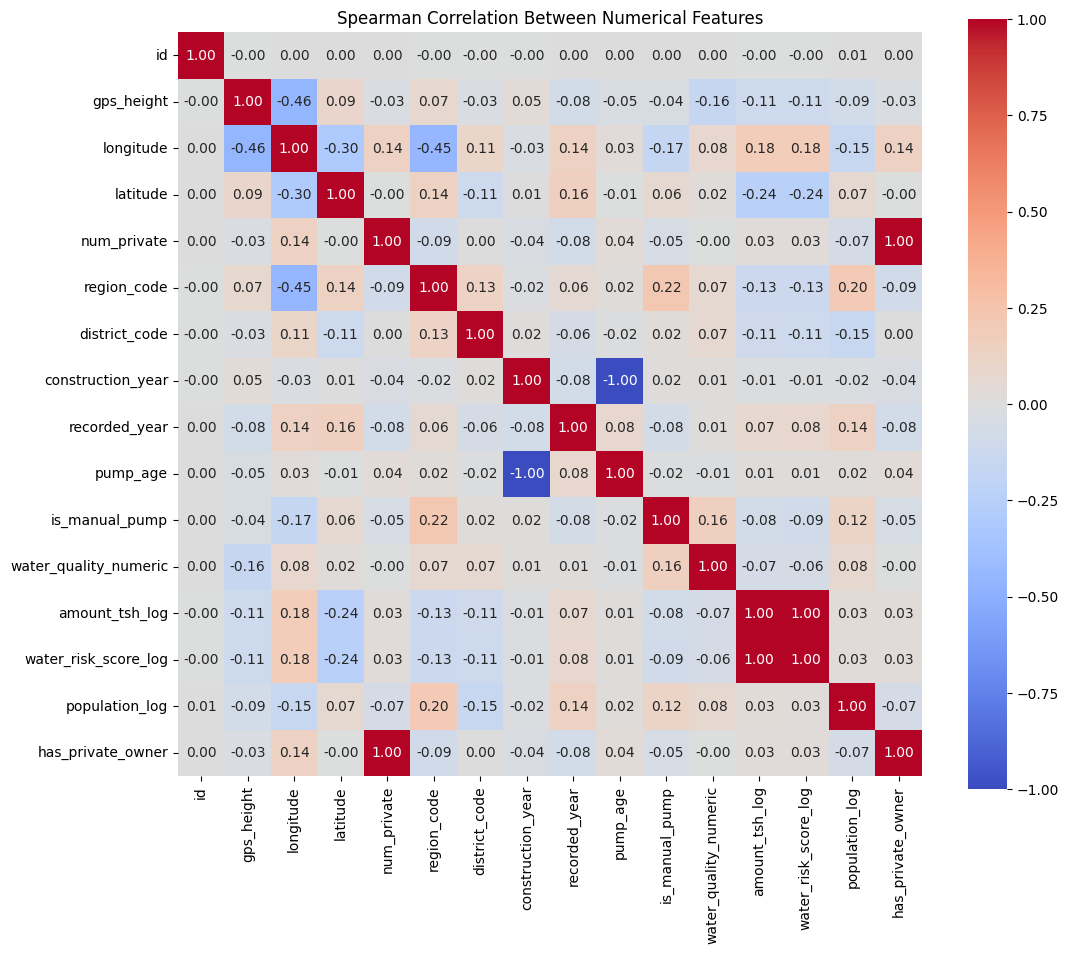

In [249]:
plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Spearman Correlation Between Numerical Features")
plt.savefig(os.path.join(out_path,"pearmanCorrelationBetweenNumerical.png"))
plt.show()

In [255]:
df.to_csv(os.path.join(data_path,'feature_engineered_data_cleaned_V1.csv'),index=False)
print("Cleaned feature data saved as: feature_engineered_data_cleaned_V1.csv")

Cleaned feature data saved as: feature_engineered_data_cleaned_V1.csv


Correlation: Categorical vs. Categorical — Using Cramér’s V

In [260]:
from scipy.stats import chi2_contingency
data_path = os.path.join(os.getcwd(), '..', 'data')
out_path = os.path.join(os.getcwd(), '..', 'outputs')   
# Read the files
train = pd.read_csv(os.path.join(data_path, 'feature_engineered_data_cleaned_V1.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))

# Drop status_group if it already exists in train
if 'status_group' in train.columns:
    train = train.drop(columns=['status_group'])
# Merge training labels
df = pd.merge(train, labels, on='id')
print('Files successfully loaded and merged!')

Files successfully loaded and merged!


In [264]:


def cramers_v(confusion_matrix):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))


In [267]:
# Select all object-type columns (categorical features)
cat_cols = df.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", cat_cols)


Categorical columns: ['funder', 'installer', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'pump_age_binned', 'status_group']


In [273]:
drop_cat_cols = [
    'date_recorded',
    'wpt_name',
    'subvillage',
    'ward',
    'recorded_by',
    'scheme_name',
    'extraction_type_group',
    'extraction_type_class',
    'management_group',
    'payment_type',
    'quality_group',
    'quantity_group',
    'source_type',
    'source_class',
    'waterpoint_type_group'
]

# Drop columns safely (only if they exist)
df = df.drop(columns=[col for col in drop_cat_cols if col in df.columns])
df.to_csv(os.path.join(data_path, 'feature_engineered_data_V2.csv'), index=False)
print("Updated dataset saved as feature_engineered_data_V2.csv")

Updated dataset saved as feature_engineered_data_V2.csv


In [280]:
# Store results in a list
cramers_results = []


In [286]:
df.columns

Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'num_private', 'region', 'region_code', 'district_code',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'management', 'payment',
       'water_quality', 'quantity', 'source', 'waterpoint_type',
       'recorded_year', 'amount_tsh_capped', 'pump_age', 'is_manual_pump',
       'water_quality_numeric', 'water_risk_score', 'amount_tsh_log',
       'water_risk_score_log', 'population_log', 'has_private_owner',
       'pump_age_binned', 'status_group'],
      dtype='object')

strongly corelation between categorical values will be investigating, before that some columns will be deleted based on previous investigations

In [291]:
cat_cols_filtered = ['has_private_owner', 'pump_age_binned','amount_tsh_capped_log',
    'basin', 'region', 'lga','population_log', 'has_private_owner'
    'management', 'payment',
    'water_quality', 'quantity', 'source',
    'waterpoint_type', 'status_group', 'water_risk_score_log'
]

In [295]:
cramers_results = []

for i in range(len(cat_cols_filtered)):
    for j in range(i + 1, len(cat_cols_filtered)):
        col1, col2 = cat_cols_filtered[i], cat_cols_filtered[j]
        try:
            confusion = pd.crosstab(df[col1], df[col2])
            score = cramers_v(confusion)
            cramers_results.append((col1, col2, score))
        except:
            continue


In [298]:
# Convert to DataFrame and sort
cramers_df = pd.DataFrame(cramers_results, columns=['Feature A', 'Feature B', 'Cramers V'])
cramers_df = cramers_df.sort_values(by='Cramers V', ascending=False)

# Show top results
print(cramers_df.head(10))


            Feature A             Feature B  Cramers V
39            payment  water_risk_score_log   0.544855
10    pump_age_binned                region   0.455118
1   has_private_owner                region   0.385847
49             source       waterpoint_type   0.376706
20             region               payment   0.358014
11    pump_age_binned        population_log   0.354502
19             region        population_log   0.324637
23             region                source   0.318459
47           quantity          status_group   0.306906
24             region       waterpoint_type   0.290312
